In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import os

In [2]:
identifier_name = 'flight_id'

top_features_names = [
    'wtc', 
    'aircraft_type', 
    'flown_distance', 
    'groundspeed_max', 
    'latitude_min', 
    'altitude_25percentile', 
    'airline', 
    'flight_duration', 
    'longitude_max', 
    'vertical_rate_75percentile', 
    'altitude_median', 
    'ades', 
    'longitude_mean', 
    'altitude_75percentile', 
    'latitude_75percentile', 
    'vertical_rate_std', 
    'adep', 
    'latitude_std', 
    'vertical_rate_max', 
    'latitude_max', 
    'longitude_std', 
    'vertical_rate_25percentile', 
    'longitude_min', 
    'longitude_75percentile', 
    'altitude_mean', 
    'groundspeed_75percentile', 
    'country_code_adep', 
    'latitude_median', 
    'longitude_25percentile', 
    'groundspeed_min', 
    'country_code_ades', 
    'latitude_25percentile', 
    'actual_offblock_time_hour', 
    'longitude_median', 
    'month', 
    'altitude_std', 
    'latitude_count', 
    'taxiout_time', 
    'vertical_rate_median', 
    'month_day'
]

target_name = 'tow'

global_random_state = 123

In [3]:
folder_path = 'data/clusters/clusters_threshold_3000'
all_files = os.listdir(folder_path)
csv_files = [f for f in all_files if f.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
combined_clusters_df = pd.concat(dataframes, ignore_index=True)
display(combined_clusters_df)

,wtc,aircraft_type,flown_distance,groundspeed_max,latitude_min,altitude_25percentile,airline,flight_duration,longitude_max,vertical_rate_75percentile,...,latitude_25percentile,actual_offblock_time_hour,longitude_median,month,altitude_std,latitude_count,taxiout_time,vertical_rate_median,month_day,tow
0,1,4,321,390.0,51.453232,9550.00,20,61,-0.443802,368.0,...,51.774945,13,-4.895513,1,11779.780447,3614.0,18,0.0,0,54748.000000
1,1,1,305,498.0,51.464942,7025.00,20,55,0.029984,768.0,...,51.682892,12,-1.853394,1,11661.560716,3265.0,14,-256.0,0,70318.447226
2,1,4,295,425.0,51.464905,7737.50,20,57,-0.061019,128.0,...,51.774136,7,-2.093523,1,12049.746662,3431.0,10,-64.0,0,56818.000000
3,1,5,257,560.0,40.158600,3450.00,14,44,33.130022,-640.0,...,40.158600,15,33.025635,1,1763.518004,809.0,25,-768.0,0,73571.000000
4,1,4,200,486.0,48.033809,7681.25,13,41,16.572653,0.0,...,48.068222,5,13.388322,1,11137.449462,2774.0,13,-640.0,0,56791.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273185,0,7,1497,492.0,40.276840,36000.00,14,212,28.724816,0.0,...,40.664886,11,12.210510,11,10115.546824,12277.0,16,0.0,313,192373.000000
273186,1,0,1562,500.0,38.273941,35975.00,18,217,17.930232,0.0,...,43.891314,9,3.075774,11,9302.054626,12966.0,11,0.0,330,72844.000000
273187,0,7,1613,474.0,41.315902,36000.00,14,223,28.725378,0.0,...,45.876113,5,13.929699,12,9753.898123,13309.0,16,0.0,335,195373.000000
273188,1,14,1348,440.0,40.144695,36000.00,14,222,33.027222,64.0,...,43.125663,11,20.065859,12,9646.272656,13282.0,10,0.0,357,62816.000000


In [4]:
features = combined_clusters_df[top_features_names]
target = combined_clusters_df[target_name]

In [5]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

In [6]:
param_grid = {
    'n_estimators': list(range(1,102,15)),
    'max_depth': list(range(1, 11, 3)),
    'learning_rate': [x / 10 for x in list(range(1, 10, 3))],
    'subsample': [x / 10 for x in list(range(1, 11, 3))],
    'colsample_bytree': [x / 10 for x in list(range(1, 11, 3))]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}
Best RMSE: 2586.995679241892


<Figure size 1000x800 with 0 Axes>

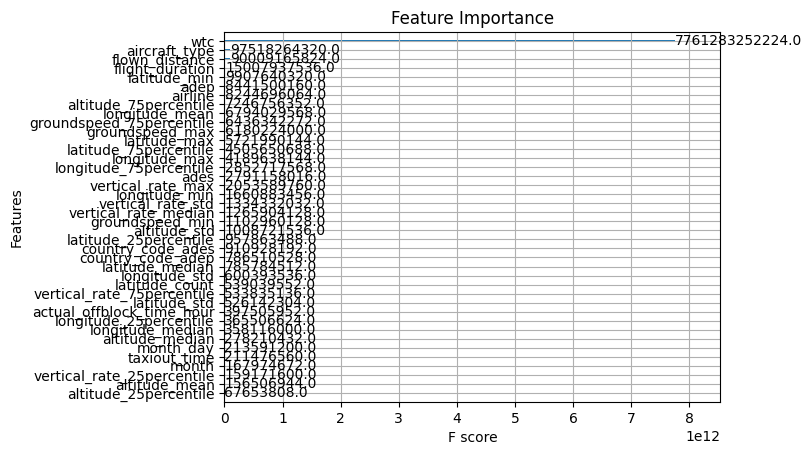

In [7]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [8]:
booster = best_model.get_booster()

# Create a DataFrame with all feature names
all_features = pd.DataFrame(features.columns, columns=['Feature'])

# Get the importance of the features
importance_dict = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Merge with all features to include those with zero importance
importance_full_df = all_features.merge(importance_df, on='Feature', how='left').fillna(0)

# Sort the DataFrame in ascending order
importance_full_df_sorted = importance_full_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

display(importance_full_df_sorted)

,Feature,Importance
0,wtc,7.761283e+12
1,aircraft_type,9.751826e+10
2,flown_distance,9.000917e+10
3,flight_duration,1.500794e+10
4,latitude_min,9.907640e+09
5,adep,8.441500e+09
6,airline,8.244696e+09
7,altitude_75percentile,7.246756e+09
8,longitude_mean,6.794030e+09
9,groundspeed_75percentile,6.436342e+09


In [9]:
print(list(importance_full_df_sorted["Importance"].values))

[7761283252224.0, 97518264320.0, 90009165824.0, 15007937536.0, 9907640320.0, 8441500160.0, 8244696064.0, 7246756352.0, 6794029568.0, 6436342272.0, 6180224000.0, 5721990144.0, 4505650688.0, 4189638144.0, 2852717568.0, 2791158016.0, 2053589760.0, 1660883456.0, 1334332032.0, 1265904128.0, 1102960128.0, 1008721536.0, 957863488.0, 910928192.0, 786510528.0, 785784512.0, 600393536.0, 539039552.0, 533835136.0, 526142304.0, 397505952.0, 365506624.0, 358116000.0, 278210432.0, 213591200.0, 211476560.0, 167974672.0, 159171600.0, 156506944.0, 67653808.0]


In [10]:
print(list(importance_full_df_sorted["Feature"].values))

['wtc', 'aircraft_type', 'flown_distance', 'flight_duration', 'latitude_min', 'adep', 'airline', 'altitude_75percentile', 'longitude_mean', 'groundspeed_75percentile', 'groundspeed_max', 'latitude_max', 'latitude_75percentile', 'longitude_max', 'longitude_75percentile', 'ades', 'vertical_rate_max', 'longitude_min', 'vertical_rate_std', 'vertical_rate_median', 'groundspeed_min', 'altitude_std', 'latitude_25percentile', 'country_code_ades', 'country_code_adep', 'latitude_median', 'longitude_std', 'latitude_count', 'vertical_rate_75percentile', 'latitude_std', 'actual_offblock_time_hour', 'longitude_25percentile', 'longitude_median', 'altitude_median', 'month_day', 'taxiout_time', 'month', 'vertical_rate_25percentile', 'altitude_mean', 'altitude_25percentile']
